In [1]:
import torch
from torch import nn

import pandas as pd
import numpy as np

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


from utils import simulate_stock_price
from utils import numpy_sequence_target

from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(device)

0
NVIDIA GeForce RTX 3070 Laptop GPU
cuda


In [3]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, number_layers, **kwargs):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_layers = number_layers
        
        self.layer_1 = nn.LSTM(self.input_size, self.hidden_size, self.number_layers, **kwargs)
        # use linear layer to produce one out feature
        if hidden_size > 1:
            self.layer_2 = nn.Linear(in_features= self.hidden_size, out_features=1, bias= False)

    def forward(self, x):
        output, (hn, cn) = self.layer_1(x)
        if self.hidden_size > 1:
            # (D âˆ— num_layers, N, H_out) drop first dimension 
            return self.layer_2(hn.squeeze(0))
        else:
            return hn

In [4]:
lstm = SimpleLSTM(input_size= 1, hidden_size= 2, number_layers= 1).to(device)

In [5]:
stock_sim_params = (0.08, 0.15, 0.01, 300, 1)
x_axis, stock_prices = simulate_stock_price(*stock_sim_params)

In [6]:
print(x_axis.shape)
print(stock_prices.shape)

(300,)
(300,)


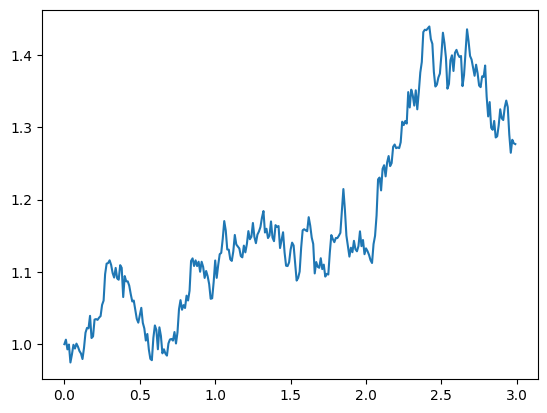

In [7]:
plt.plot(x_axis, stock_prices)
plt.show()

In [35]:
X, y = numpy_sequence_target(time_series= stock_prices, sequence_length= 10)

In [36]:
print(X.shape)
print(y.shape)

(290, 10, 1)
(290,)


In [37]:
X = torch.tensor(X, dtype= torch.float32, device= device)
y = torch.tensor(y, dtype= torch.float32, device= device)

In [38]:
# Wrap dataset
dataset = TensorDataset(X, y)
# Create DataLoader with batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
EPOCHS = 3000
LEARNING_RATE = 1e-5
optimizer = torch.optim.Adam(params= lstm.parameters(), lr= LEARNING_RATE)
loss_fn = nn.MSELoss()

In [ ]:
for epoch in range(1, EPOCHS):
    for X, y in dataloader:
        
        # set model to train
        lstm.train()
        
        # 1. forward pass
        # (sequence_length, batch_size, in_features)
        X_seq = X.permute(1,0,2)
        
        output = lstm(X_seq)
        
        # 2. calculate loss (input, target)
        loss = loss_fn(output, y.unsqueeze(-1))
        
        # 3. zero out gradients
        # optimizer holds the grandients of the parameters and should be 0 before the next backpropagation
        optimizer.zero_grad()
        
        # 4. backpropagation
        loss.backward()
    
        # 5. update parameters
        optimizer.step()
    
    # # 6. evaluate model
    # with torch.inference_mode():
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:5} | Loss: {loss:5.2f}')


In [39]:
for X, y in dataloader:
    print(X.permute(1,0,2).shape)
    print(y.shape)
    
    break

torch.Size([10, 32, 1])
torch.Size([32])


In [24]:
test_forecast = None
for X, y in dataloader:
    X_seq = X.permute(1,0,2)
    if test_forecast == None:
        with torch.inference_mode():
            test_forecast = lstm(X_seq)
            print(test_forecast.shape)

torch.Size([32, 1])


In [533]:
test_forecast = None
lstm.eval()
for X, y in dataloader:
    X_seq = X.permute(1,0,2)
    if test_forecast == None:
        with torch.inference_mode():
            test_forecast = lstm(X_seq)
            
    else:
        with torch.inference_mode():
            output = lstm(X_seq)
            print(output)
            break
            test_forecast = torch.vstack((test_forecast, output))

tensor([[0.8552],
        [0.9388],
        [0.9635],
        [0.8597],
        [1.0036],
        [0.9472],
        [0.9388],
        [0.9381],
        [0.9187],
        [0.9526],
        [0.9004],
        [0.9455],
        [1.0021],
        [0.9567],
        [1.0243],
        [0.8537],
        [0.9401],
        [0.9797],
        [1.0029],
        [0.9757],
        [0.9387],
        [0.9178],
        [0.9849],
        [0.9716],
        [0.9753],
        [1.0117],
        [0.9169],
        [0.8856],
        [0.9431],
        [1.0120],
        [1.0138],
        [0.9415]], device='cuda:0')


In [517]:
test_forecast.shape

torch.Size([290, 1])

In [518]:
test_forecast_numpy = np.array(test_forecast.squeeze(1).cpu().detach().numpy())

In [519]:
test_forecast_numpy.shape

(290,)

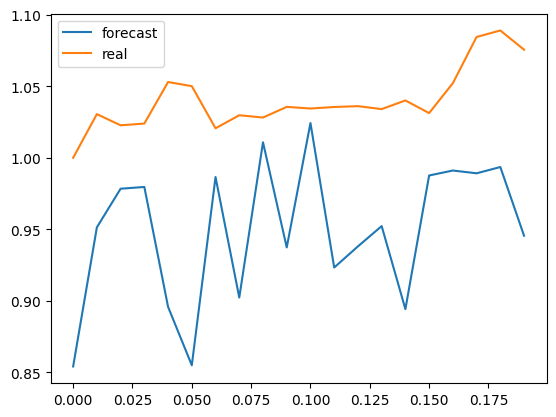

In [528]:
plt.plot(x_axis[0:20], test_forecast_numpy[0:20], label= 'forecast')
plt.plot(x_axis[0:20], stock_prices[0:20], label= 'real')
plt.legend()
plt.show()

In [522]:
list(zip(stock_prices, test_forecast_numpy))

[(np.float64(1.0), np.float32(0.8540839)),
 (np.float64(1.0305325040996949), np.float32(0.9513582)),
 (np.float64(1.0227070910280172), np.float32(0.97837603)),
 (np.float64(1.0239295182507153), np.float32(0.9796057)),
 (np.float64(1.0529753543723868), np.float32(0.8957597)),
 (np.float64(1.050089882503296), np.float32(0.85493934)),
 (np.float64(1.0206257558826881), np.float32(0.9865489)),
 (np.float64(1.0297465946463698), np.float32(0.9022833)),
 (np.float64(1.0281428826781709), np.float32(1.0108517)),
 (np.float64(1.0356041717474254), np.float32(0.93733704)),
 (np.float64(1.0344475112508318), np.float32(1.0242989)),
 (np.float64(1.0355216117548602), np.float32(0.92327714)),
 (np.float64(1.0360980622687583), np.float32(0.9380511)),
 (np.float64(1.0340469129132044), np.float32(0.9522355)),
 (np.float64(1.0400845165390855), np.float32(0.8941957)),
 (np.float64(1.0312582116719498), np.float32(0.98762393)),
 (np.float64(1.0521651974746082), np.float32(0.9911006)),
 (np.float64(1.0844677906